In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import matplotlib.patches as mpatches
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.utils import resample
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import scikitplot as skplt
from sklearn.metrics import confusion_matrix

code based on :
https://www.youtube.com/watch?v=WYaNdxmlYUg

### Load Data

In [2]:
wtr=pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2021/2021-05-04/water.csv')

In [3]:
wtr.head()

,row_id,lat_deg,lon_deg,report_date,status_id,water_source,water_tech,facility_type,country_name,install_year,installer,pay,status
0,3957,8.073136,38.617037,04/06/2017,y,NaN,NaN,NaN,Ethiopia,NaN,Private-CRS,NaN,NaN
1,33512,7.373784,40.503824,08/04/2020,y,Protected Spring,NaN,Improved,Ethiopia,2019.0,WaterAid,NaN,NaN
2,35125,0.773458,34.929509,03/18/2015,y,Protected Shallow Well,NaN,Improved,Kenya,NaN,NaN,NaN,NaN
3,37760,0.780576,34.963640,03/18/2015,y,Borehole,NaN,Improved,Kenya,NaN,NaN,NaN,NaN
4,38118,0.779266,34.971120,03/18/2015,y,Protected Shallow Well,NaN,Improved,Kenya,NaN,NaN,NaN,NaN


Each row is source of water
status id-->Y yes water is available
U--> unknown

In [314]:
wtr.describe()

,row_id,lat_deg,lon_deg,install_year
count,473293.000000,473293.000000,473293.000000,339003.000000
mean,277392.271244,1.581829,16.870186,2002.472775
std,170322.431844,10.202556,19.136223,11.864804
min,1.000000,-88.996556,-140.739594,1900.000000
25%,131158.000000,-0.628585,-0.724249,1998.000000
50%,253676.000000,4.933805,29.388622,2006.000000
75%,427525.000000,8.420984,32.204302,2010.000000
max,577803.000000,85.000000,179.483383,2045.000000


In [315]:
wtr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 473293 entries, 0 to 473292
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   row_id         473293 non-null  int64  
 1   lat_deg        473293 non-null  float64
 2   lon_deg        473293 non-null  float64
 3   report_date    473293 non-null  object 
 4   status_id      473293 non-null  object 
 5   water_source   410579 non-null  object 
 6   water_tech     290703 non-null  object 
 7   facility_type  410485 non-null  object 
 8   country_name   473283 non-null  object 
 9   install_year   339003 non-null  float64
 10  installer      115742 non-null  object 
 11  pay            258323 non-null  object 
 12  status         363298 non-null  object 
dtypes: float64(3), int64(1), object(9)
memory usage: 46.9+ MB


In [316]:
wtr.status_id.unique()

array(['y', 'u', 'n'], dtype=object)

Lots of NA values
pay--> whether people have to pay for data

### Explore data
When have spatial info, make map

In [4]:
df=wtr.loc[wtr['status_id']!='u',:]

In [5]:
#fig = go.Figure(data=go.Scattergeo(
#        lon = df['lon_deg'],
#        lat = df['lat_deg'],
#        mode = 'markers'
#        ))
#
#fig.update_layout(
#        title = 'Most trafficked US airports<br>(Hover for airport names)',
#        
#    )
#very slow
#fig.show()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='lon_deg', ylabel='lat_deg'>

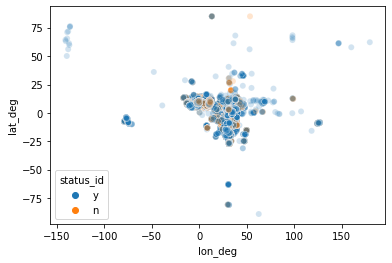

In [6]:
sns.scatterplot('lon_deg','lat_deg',alpha=0.2,hue='status_id',data=df)

In [7]:
#filtering by country
wtr['country_name'].value_counts()

Uganda                      119671
Nigeria                      83703
Sierra Leone                 67706
Liberia                      33781
Ethiopia                     25917
Tanzania                     24923
Swaziland                    23913
Zimbabwe                     23695
Ghana                        21334
Kenya                        12153
Zambia                        9093
Congo - Kinshasa              7958
South Sudan                   6885
Rwanda                        2953
Mozambique                    2478
Central African Republic      2447
Niger                         1101
Burkina Faso                   820
Madagascar                     800
Mali                           648
Peru                           579
Timor-Leste                    400
Gambia                         149
Chad                            35
Sudan                           34
Congo - Brazzaville             29
Namibia                         21
South Africa                    15
Algeria             

### Filtering to Sierra Leone Only

In [8]:
df=df[(df['country_name']=='Sierra Leone') & (df['lat_deg']>0)&(df['lat_deg']<15)&(df['lon_deg']<0)]

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='lon_deg', ylabel='lat_deg'>

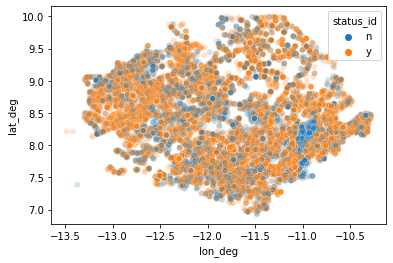

In [9]:
sns.scatterplot('lon_deg','lat_deg',alpha=0.2,hue='status_id',data=df)

### Model Creation
Dropping unused columns such as country name, status and report_date

In [10]:
water=df[df.columns[~df.columns.isin(['country_name','status','report_date'])]]

#### checking levels for featuring engg...bundle less frequenctly occuring levels today

In [11]:
water['pay'].value_counts()

No- water is free                            20020
No payment – its free                        17190
Only if there is a breakdown                  2561
No water                                      1806
Yes, Flat rate (LE/HH/month)                  1034
                                             ...  
No  water                                        1
Never water                                      1
Yes, per jerrican Yes, per jerrican 20L0L        1
It was bought                                    1
Contains Micro organisms                         1
Name: pay, Length: 62, dtype: int64

In [12]:
water['water_tech'].value_counts(normalize=True)

Hand Pump - India Mark     0.317369
Rope and Bucket            0.272651
Tapstand                   0.223129
Hand Pump - Kardia         0.079227
Hand Pump                  0.035554
Hand Pump - PB Mark II     0.018631
Hand Pump - Afridev        0.018370
Hand Pump - Inkar          0.012360
Kiosk                      0.010069
Mechanized Pump            0.008542
Hand Pump - Consallen      0.002050
Hydram                     0.001246
Hand Pump - Vergnet        0.000764
Mechanized Pump - Solar    0.000040
Name: water_tech, dtype: float64

In [13]:
water['facility_type'].value_counts()

Improved         29612
Unimproved        8506
No facilities      229
Unknown             90
Name: facility_type, dtype: int64

In [14]:
water['install_year'].value_counts()

2010.0    4090
2011.0    3975
2009.0    2930
2003.0    2926
2008.0    2711
          ... 
1943.0       2
1942.0       2
1932.0       2
1934.0       1
1931.0       1
Name: install_year, Length: 78, dtype: int64

In [15]:
water['installer'].value_counts()

Private Person                              7350
Private                                     3325
Government                                  2779
Other                                       2646
Religious Group                             2371
                                            ... 
world vission area development programme       1
JAPAN  S.L.                                    1
cordsl                                         1
CARITAS AND CORDAID NETHERLANDS                1
uniself                                        1
Name: installer, Length: 2842, dtype: int64

In [16]:
water['water_source'].value_counts()

Protected Shallow Well                        22346
Unprotected Shallow Well                       8411
Borehole                                       4391
Piped Water                                    1773
Protected Spring                                589
Sand or Sub-surface Dam                         430
Surface Water (River/Stream/Lake/Pond/Dam)      229
Unprotected Spring                               95
Undefined Shallow Well                           86
Rainwater Harvesting                             83
Delivered Water                                  15
Undefined Spring                                  4
Name: water_source, dtype: int64

#### Feature Engineering

In [17]:
# collapse multiple paytypes..
# if starts with No just say No, if starts with Yes, Say yes..null stay the same and otherwise its complicate\d
water['pay']=np.where(water['pay'].str.startswith('No', na=False),'No',np.where(water['pay'].str.startswith('Yes', na=False),'Yes',np.where(water['pay'].isna(), np.nan,'its complicated')))
#water.loc[water['pay'].str.startswith('No', na=False),'pay']='No'
#water.loc[water['pay'].str.startswith('Yes', na=False),'pay']='Yes'
#water.loc[water['pay'].str.startswith('No', na=False),'pay']='No'

<ipython-input-17-a838088bf497>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  water['pay']=np.where(water['pay'].str.startswith('No', na=False),'No',np.where(water['pay'].str.startswith('Yes', na=False),'Yes',np.where(water['pay'].isna(), np.nan,'its complicated')))


In [18]:
water['pay'].value_counts()

No                 39026
nan                 9808
its complicated     3091
Yes                 2868
Name: pay, dtype: int64

In [19]:
### Multiple 'Hand Pump Entries'-- collapse to single
#water['water_tech']= 
water.loc[water['water_tech'].str.startswith('Hand Pump', na=False),'water_tech']='Hand Pump'

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


### Older water sources are less likely to have water available and newer ones are more likely to have it avaialble

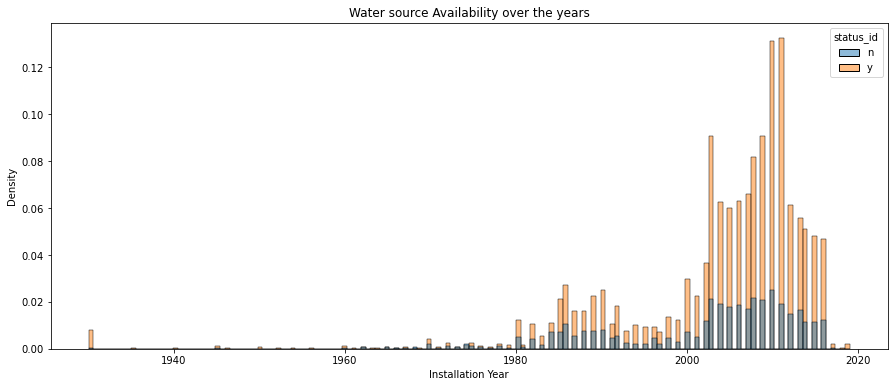

In [20]:
#histogram
plt.figure(figsize=(15,6))

sns.histplot(data= water, x='install_year',kde=False, stat="density", hue='status_id',alpha=0.5)
#plt.legend(title='Water Available?', prop={'size': 12})
plt.title('Water source Availability over the years')
plt.xlabel('Installation Year')
plt.ylabel('Density')
plt.show()
#px.histogram(water,x='install_year',color='status_id')

#### Payment Types vs Water source availability
Having a NA value for payment is hugely associated with water not being available

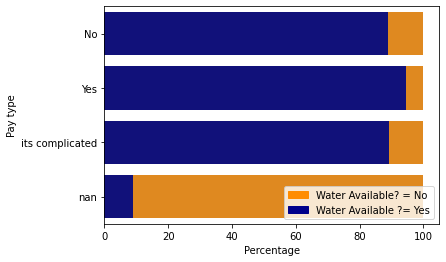

In [21]:
total=water.groupby('pay')['status_id'].count().reset_index()
wtr_y=water[water.status_id=='y'].groupby('pay')['status_id'].count().reset_index()
wtr_y['y_pct']=[i/j *100 for i,j in zip(wtr_y['status_id'],total['status_id'])]
total['y_pct']=[i/j *100 for i,j in zip(total['status_id'],total['status_id'])]

# bar chart 1 -> top bars (group of 'water=No')
bar1 = sns.barplot(y="pay",  x="y_pct", data=total, color='darkorange')

# bar chart 2 -> bottom bars (group of 'smoker=Yes')
bar2 = sns.barplot(y="pay", x="y_pct", data=wtr_y, color='darkblue')

# add legend
top_bar = mpatches.Patch(color='darkorange', label='Water Available? = No')
bottom_bar = mpatches.Patch(color='darkblue', label='Water Available ?= Yes')
plt.legend(handles=[top_bar, bottom_bar])
plt.xlabel('Percentage')
plt.ylabel('Pay type')
# show the graph
plt.show()

### Preprocessing

In [22]:
#stratified split by 'status_id' into training and testing
#X=water[water.columns[~water.columns.isin(['status_id'])]]#.values
X=water
y=water.loc[:,'status_id']#.values #.values converts to numpy ndarray needed for stratfied k fold
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.25)
X_test=X_test[X_test.columns[~X_test.columns.isin(['status_id'])]]

In [23]:
X_test.head()

,row_id,lat_deg,lon_deg,water_source,water_tech,facility_type,install_year,installer,pay
247313,267808,8.622331,-10.942224,Protected Shallow Well,Hand Pump,Improved,2005.0,UNICEF,nan
413510,505938,9.351719,-12.660261,Protected Shallow Well,Hand Pump,Improved,1993.0,Action Aid,No
416629,504048,9.549667,-12.284527,Protected Shallow Well,Hand Pump,Improved,2010.0,United Nations (UN),No
237362,257098,7.778377,-11.770757,Protected Shallow Well,Hand Pump,Improved,2016.0,World Vision,No
422511,509970,8.396580,-13.143620,NaN,Tapstand,NaN,2006.0,GVWC,No


In [24]:
X_train.status_id.value_counts()


y    30764
n    10330
Name: status_id, dtype: int64

##### Downsample prediction variable

In [25]:
#downsample
# Separate majority and minority classes
X_train_majority = X_train[X_train.status_id=='y']
X_train_minority = X_train[X_train.status_id=='n']
 
# Downsample majority class
X_train_majority_downsampled = resample(X_train_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=10330,     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
X_train_downsampled = pd.concat([X_train_majority_downsampled, X_train_minority])
 
# Display new class counts
X_train_downsampled.status_id.value_counts()

n    10330
y    10330
Name: status_id, dtype: int64

In [26]:
X_train=X_train_downsampled
y_train=X_train.loc[:,'status_id']
X_train=X_train[X_train.columns[~X_train.columns.isin(['status_id'])]]
X_train.head()

,row_id,lat_deg,lon_deg,water_source,water_tech,facility_type,install_year,installer,pay
422043,508072,8.846338,-12.842955,Protected Shallow Well,Hand Pump,Improved,2007.0,Webco,No
211819,224889,8.349980,-12.842480,Protected Shallow Well,Hand Pump,Improved,1991.0,Care,No
241461,260224,8.627976,-11.664382,Protected Shallow Well,Hand Pump,Improved,2013.0,UNICEF,No
251813,264467,7.886657,-11.189187,NaN,Rope and Bucket,NaN,2009.0,NaN,No
417099,504695,8.376578,-12.428606,Protected Shallow Well,Hand Pump,Improved,1985.0,UMCOR,No


In [27]:
y_train

422043    y
211819    y
241461    y
251813    y
417099    y
         ..
423182    n
389971    n
243333    n
239828    n
396985    n
Name: status_id, Length: 20660, dtype: object

#### Treating multiple levels

Change NA levels to unknown for object datatypes

In [28]:
#fill NA by 'unknown' level for object dtypes , replace less frequent levels by 'other'
X_train.loc[:,X_train.select_dtypes(include = ["object"]).columns] = X_train.select_dtypes(include=['object']).apply(lambda x :x.fillna('unknown'))
#X_train.fillna('unknown')

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1717: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)


In [29]:
#TODO: change pay nan to unknown
X_train.loc[X_train.pay=='nan','pay']='unknown'

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [30]:
X_train.loc[X_train.pay=='nan']

,row_id,lat_deg,lon_deg,water_source,water_tech,facility_type,install_year,installer,pay


For categories <3% assign 'other' factor level

In [31]:

X_train=X_train.apply(lambda x: x.mask(x.map(x.value_counts(normalize=True))<0.03, 'other') if x.dtype=='object' else x)
X_train['installer'].value_counts(normalize=True)

other                  0.431220
unknown                0.125266
Private Person         0.106050
Government             0.055808
Other                  0.049516
Private                0.048887
Religious Group        0.041142
United Nations (UN)    0.040707
Water Aid              0.036689
GVWC                   0.033059
Community              0.031655
Name: installer, dtype: float64

'Install_year' NA impute using linear model

In [32]:
X_train['install_year'].isna().sum()
X_train_num=X_train.select_dtypes(include=np.number)

In [33]:
# Regression imputation
imputer = IterativeImputer(BayesianRidge())
imputed_X_train_n = pd.DataFrame(imputer.fit_transform(X_train_num))
imputed_X_train_n.columns=X_train_num.columns
imputed_X_train_n['install_year'].isna().sum()

0

In [34]:
#join back to original dataset
X_train_new=X_train.reset_index(drop=True)
X_train_new=pd.concat([X_train_new,imputed_X_train_n[['install_year']]],axis=1)
X_train_new = X_train_new.dropna(axis='columns')
X_train_new.head()

,row_id,lat_deg,lon_deg,water_source,water_tech,facility_type,installer,pay,install_year
0,508072,8.846338,-12.842955,Protected Shallow Well,Hand Pump,Improved,other,No,2007.0
1,224889,8.349980,-12.842480,Protected Shallow Well,Hand Pump,Improved,other,No,1991.0
2,260224,8.627976,-11.664382,Protected Shallow Well,Hand Pump,Improved,other,No,2013.0
3,264467,7.886657,-11.189187,unknown,Rope and Bucket,unknown,unknown,No,2009.0
4,504695,8.376578,-12.428606,Protected Shallow Well,Hand Pump,Improved,other,No,1985.0


In [35]:
X_train_new['water_source'].unique()

array(['Protected Shallow Well', 'unknown', 'Unprotected Shallow Well',
       'Borehole', 'other', 'Piped Water'], dtype=object)

In [36]:
X_train_new['water_tech'].unique()

array(['Hand Pump', 'Rope and Bucket', 'other', 'Tapstand', 'unknown'],
      dtype=object)

##### Dummy Encodeing

In [37]:
X_train_new2=X_train_new.copy()
X_train_new2=pd.get_dummies(X_train_new2)

In [38]:
# water[water.pay=='nan']
X_train=X_train_new2.copy()
X_train_new2.isna().sum()


row_id                                   0
lat_deg                                  0
lon_deg                                  0
install_year                             0
water_source_Borehole                    0
water_source_Piped Water                 0
water_source_Protected Shallow Well      0
water_source_Unprotected Shallow Well    0
water_source_other                       0
water_source_unknown                     0
water_tech_Hand Pump                     0
water_tech_Rope and Bucket               0
water_tech_Tapstand                      0
water_tech_other                         0
water_tech_unknown                       0
facility_type_Improved                   0
facility_type_Unimproved                 0
facility_type_other                      0
facility_type_unknown                    0
installer_Community                      0
installer_GVWC                           0
installer_Government                     0
installer_Other                          0
installer_P

##### Match indexing of y to x

In [39]:
y_train.reset_index(drop=True, inplace=True)

##### 10 fold stratified cross validation

Fold 1  has score 0.8683446272991288
Fold 2  has score 0.8862536302032914
Fold 3  has score 0.8756050338818974
Fold 4  has score 0.8843175217812197
Fold 5  has score 0.8780251694094869
Fold 6  has score 0.8814133591481123
Fold 7  has score 0.8809293320425944
Fold 8  has score 0.8872216844143272
Fold 9  has score 0.8697967086156825
Fold 10  has score 0.8683446272991288


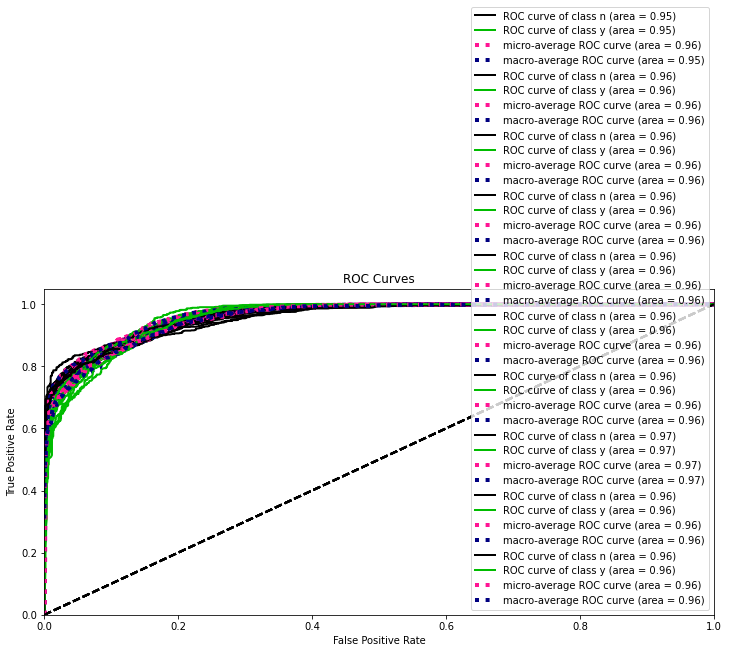

In [40]:
#not tune needed as multiple trees 
# define the model
model = RandomForestClassifier(n_estimators=1000)
lst_accu_stratified=[]
aucs=[]
fold_no = 1
fig, ax = plt.subplots(figsize=(12, 6))
#use training data to create k fold cross validation sets stratified on status_id
skf=StratifiedKFold(n_splits=10, random_state=None, shuffle=False)
for train_index, test_index in skf.split(X_train, y_train):
#      print("TRAIN:", train_index, "Holdout:", test_index)
    x_train_fold, x_test_fold = X_train.loc[train_index,:], X_train.loc[test_index,:]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
    model.fit(x_train_fold, y_train_fold)
    lst_accu_stratified.append(model.score(x_test_fold, y_test_fold))
    print(f'Fold {fold_no}  has score {model.score(x_test_fold, y_test_fold)}')
    y_probs = model.predict_proba(x_test_fold)
    # keep probabilities for the positive outcome only
    rf_probs = y_probs[:, 1]
    # calculate scores
    skplt.metrics.plot_roc(y_test_fold, y_probs,ax=ax)
    rf_auc = roc_auc_score(y_test_fold, rf_probs)
    aucs.append(rf_auc)
    fold_no += 1
plt.show()

##### Explore CV results

In [41]:
#Mean accuracy
np.mean(lst_accu_stratified),np.mean(aucs)

(0.878025169409487, 0.9603116984618902)

##### Fit on training

In [42]:
model = RandomForestClassifier(n_estimators=1000)
model.fit(X_train,y_train)
y_pred_test=model.predict(X_test)
confusion_matrix(y_test,y_pred_test)

ValueError: could not convert string to float: 'Protected Shallow Well'